# IATS 2019 - Image Analysis Training School at the University of Nottingham
## Vincenzo Della Mea, MITEL, University of Udine

This [Jupyter](https://jupyter.org) notebook is aimed at introducing IATS 2019 attendants to the application of CNNs to histologic images, with an easy learning path based on [Fastai](https://www.fast.ai). It does not aim at people already expert in Python and deep learning.

It is in no way exhaustive, and also the image data set provided cannot be considered more than an example of what can be done. 
The image set comes from a larger digital slide repository developed during the EU MSCA [AIDPATH](http://aidpath.eu) project. However, for this exercise only some image has been used.

Before running code, please set the runtime type to use a GPU (Menu *Runtime: Runtime type: Hardware Accelerator: GPU*). In the same dialog, runtime type should be set as **Python 3**.


---

The next cells include either instructions and explanations or Python code, plus sometimes shell commands prefixed by "!". You may run them one by one, or all together from the "*Runtime*" Menu.


The next cell is used to setup the Fastai environment, and to include useful libraries. Click on the "[ ]" icon on the left side to run it.

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

from fastai import *
from fastai.vision import *
import numpy as np
from google.colab import files
from zipfile import ZipFile


Updating fastai...
Done.


Now let's import the image set we will use for the exercise. We will get it from MITEL web site.

In [2]:
!wget https://mitel.dimi.uniud.it/IATS2019/IATS2019.zip
with ZipFile('IATS2019.zip', 'r') as zf:
    zf.extractall('data/')
!ls data

--2019-09-25 10:40:29--  https://mitel.dimi.uniud.it/IATS2019/IATS2019.zip
Resolving mitel.dimi.uniud.it (mitel.dimi.uniud.it)... 158.110.147.192
Connecting to mitel.dimi.uniud.it (mitel.dimi.uniud.it)|158.110.147.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41097823 (39M) [application/zip]
Saving to: ‘IATS2019.zip’

IATS2019.zip        100%[===================>]  39.19M  8.87MB/s    in 4.4s    

2019-09-25 10:40:34 (8.87 MB/s) - ‘IATS2019.zip’ saved [41097823/41097823]

IATS2019


Now set some parameters used in the process. 
Regarding the model, you may find a list [here](https://docs.fast.ai/vision.models.html).
With the parameters chosen, we will do transfer learning on a a model pretrained on the [Imagenet](http://www.image-net.org) image set. This will save us time (less epochs needed).

In [0]:
path='data/IATS2019'
batch_size=32 #this can be changed because it effects results, however if too large, GPU memory will not suffice
resize=256 #current CNN model use very small images (e.g., 224x224); you can let this be as large as our images (512) but not too much
model = models.resnet34 #you may try with other pretrained models, e.g.,  resnet152
epochs=3
outfile = 'predictions.csv'


In the next cell we prepare the learner object (*classifier*), starting from the transformed and normalised image set.

In [4]:
tfms = get_transforms(max_zoom=1.1) #to augment the data set,  a number of transformations is usually done, e.g., flipping, rotating, slight zooming, etc
images = ImageDataBunch.from_folder(path,ds_tfms=tfms, size=resize, bs=batch_size,test='test')
images.normalize(imagenet_stats)
classifier = cnn_learner(images, model, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 81703853.98it/s]


Before starting the process, let's look at our images.

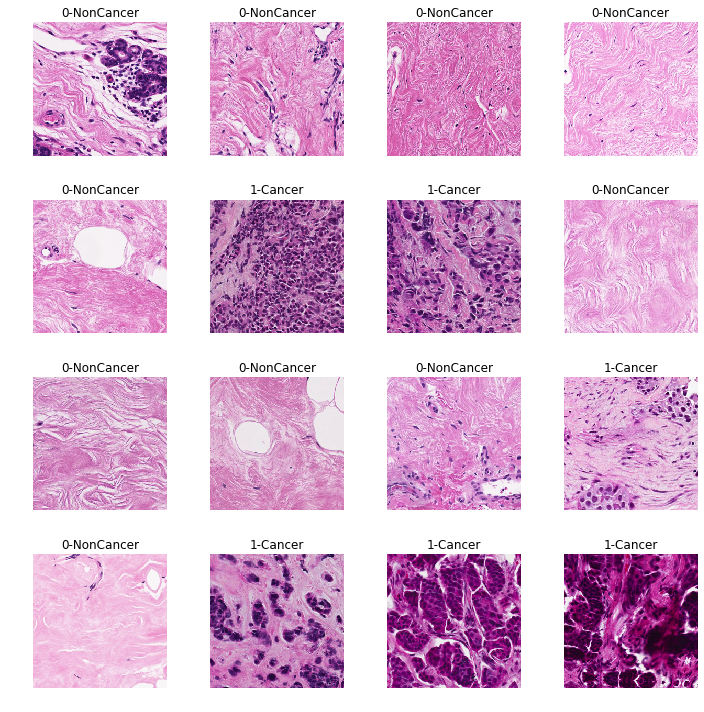

In [5]:
images.show_batch(rows=4, figsize=(10,10))

Finally, we  can start **training**. Done this way, only the last layer of the network is trained. It could be sufficient or not, depending on the image set. You will see the output epoch by epoch, including accuracy on the validation set (but be careful, not always accuracy is sufficient to evaluate performance).

In [6]:
classifier.fit_one_cycle(epochs)

In a complete process, you may want to train also the first layers of the network, typically after having trained the last as above, and for less epochs. To do so, you have to "unfreeze" the network.

In [7]:
classifier.unfreeze()
classifier.fit_one_cycle(2)

Before classifying our test set, let's look at results.

[('0-NonCancer', '1-Cancer', 1)]

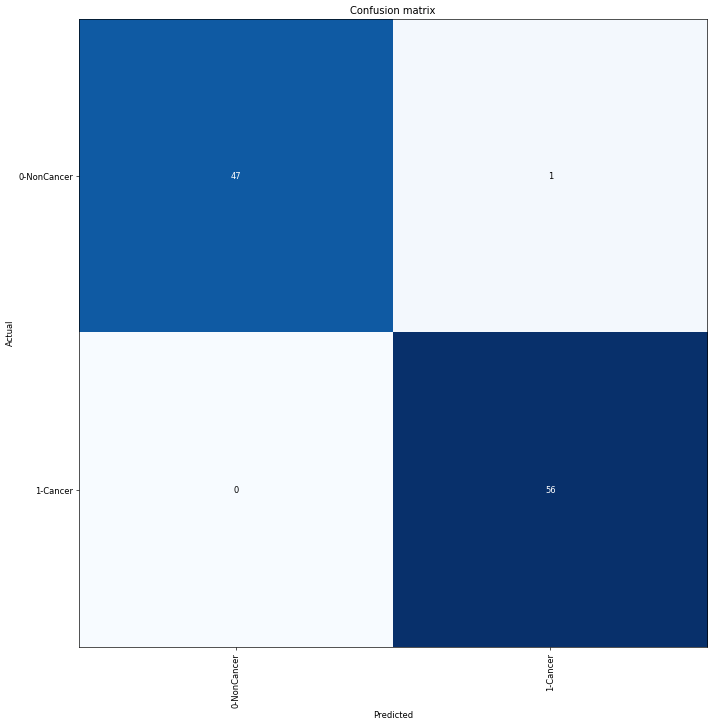

In [8]:
interp = ClassificationInterpretation.from_learner(classifier)
losses,idxs = interp.top_losses()
len(images.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused(min_val=1)


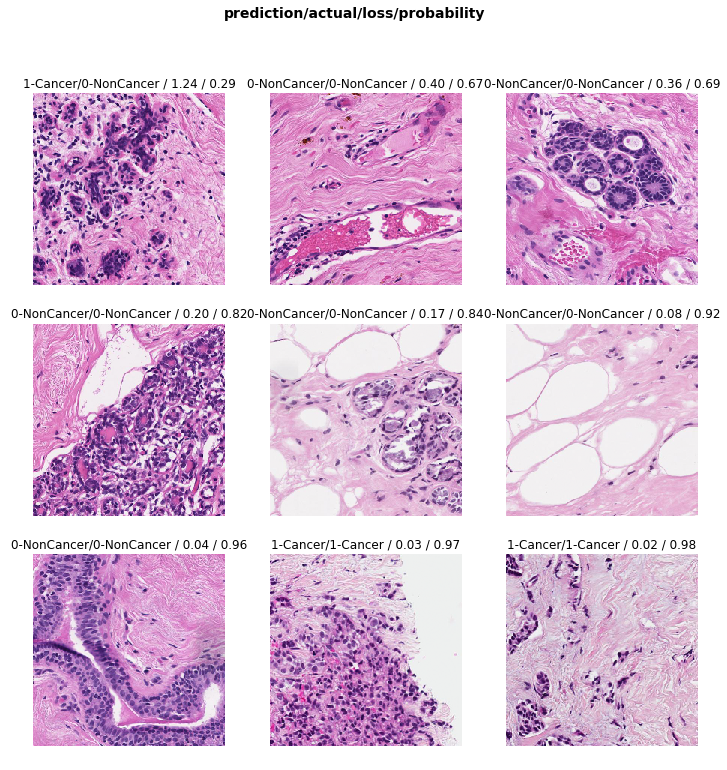

In [9]:
interp.plot_top_losses(9, figsize=(12,12))

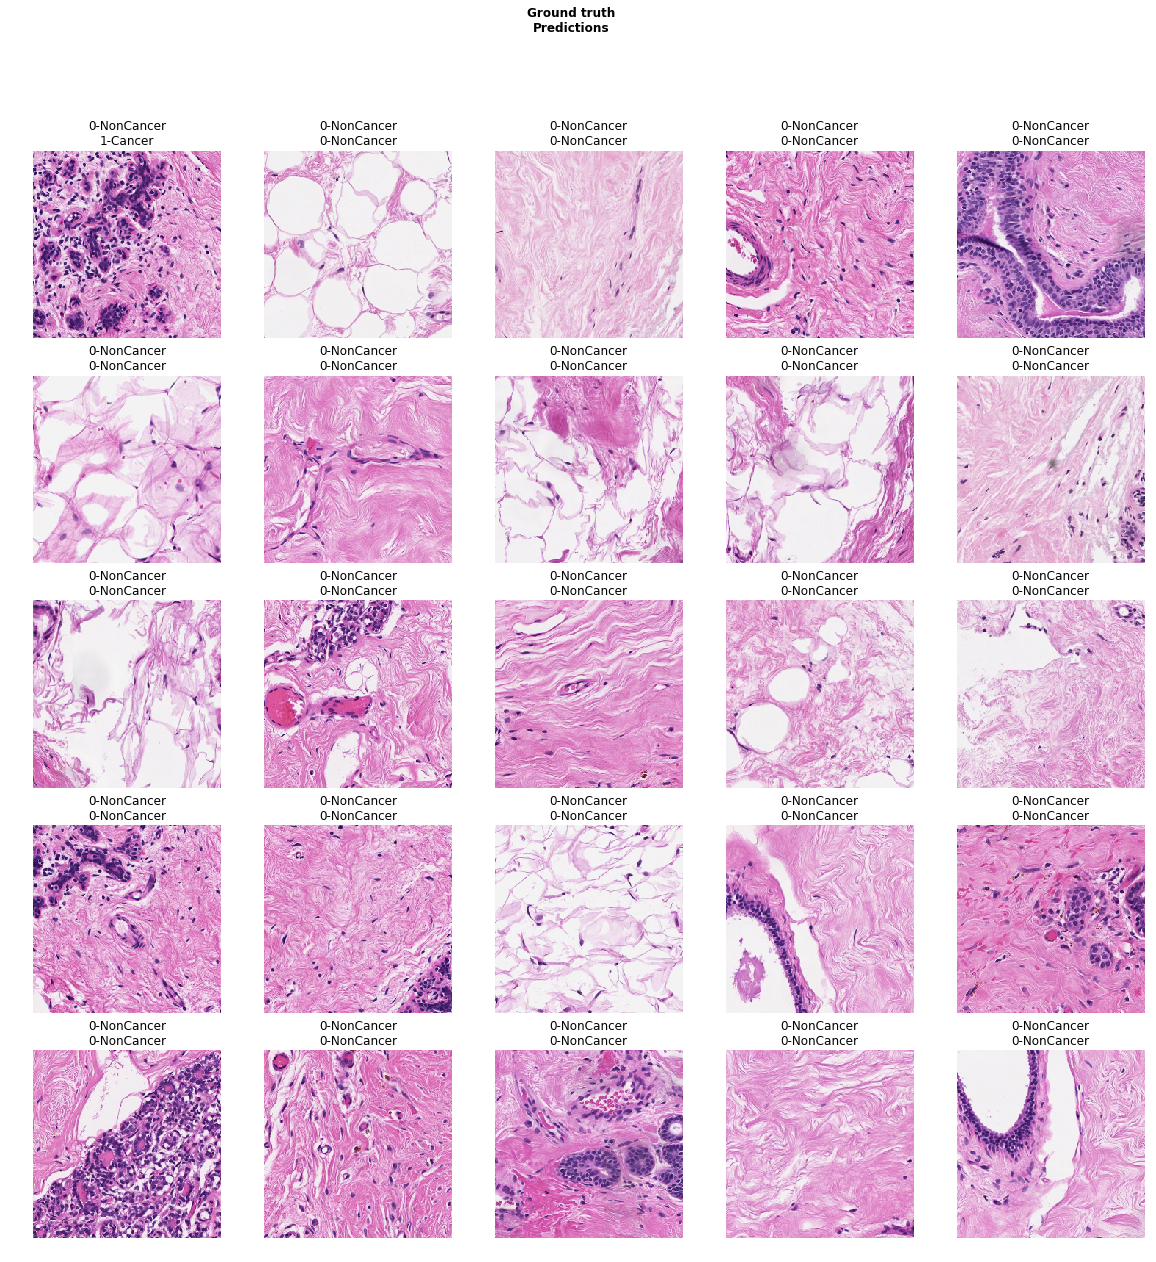

In [10]:
classifier.show_results()

## Predictions
We can finally predict the classes for the test set. There are other ways of doing this. 
The output is a CSV file with the proposed class (all those >0.6 probability), and also the probability of each class. 
If you have more than two classes, you might have more than one proposed class.

In [0]:
preds, y = classifier.get_preds(ds_type=DatasetType.Test)
thresh = 0.6
labelled_preds = [' '.join([classifier.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
fnames = [f.name[:-2] for f in classifier.data.test_ds.items]
df = pd.DataFrame({'image_name':fnames, 'class':labelled_preds, 'NonCancer':preds.numpy()[:, 0], 'Cancer':preds.numpy()[:, 1]}, 
                  columns=['image_name', 'class','NonCancer','Cancer'])
df.to_csv(outfile, index=False)


In [0]:
files.download(outfile)

## Some extras

You may save the trained model for further use:

In [13]:
classifier.export()

NameError: ignored